<a href="https://colab.research.google.com/github/BhumikaAdhya05/Pneumonia_Detection/blob/main/Pneumonia_Detection_from_Chest_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import json

In [3]:
from google.colab import files
files.upload()  # Select kaggle.json from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhumikaadhya05","key":"76f7c91a508c639053f3ec8ca5a655a0"}'}

In [4]:
# Move kaggle.json to correct location
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.rename('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [5]:
import zipfile

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("chest_xray")

print("✅ Dataset downloaded and extracted.")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
✅ Dataset downloaded and extracted.


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = "chest_xray/chest_xray/train"
val_dir = "chest_xray/chest_xray/val"
test_dir = "chest_xray/chest_xray/test"

In [8]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Just rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [10]:
# Load base model (without top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base model

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
checkpoint = ModelCheckpoint('pneumonia_detector.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,

    epochs=10,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8795 - loss: 0.2909

163/163 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.8797 - loss: 0.2904 - val_accuracy: 0.8750 - val_loss: 0.2426
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9400 - loss: 0.1485

163/163 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9400 - loss: 0.1485 - val_accuracy: 0.9375 - val_loss: 0.1983
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9424 - loss: 0.1449 - val_accuracy: 0.8750 - val_loss: 0.2664
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9471 - loss: 0.1368

163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9471 - loss: 0.1368 - val_accuracy: 0.8750 - val_loss: 0.1957
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9530 - loss: 0.1234 - val_accuracy: 0.8125 - val_loss: 0.2974
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9525 - loss: 0.1104 - val_accuracy: 0.8750 - val_loss: 0.2495
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9529 - loss: 0.1155 - val_accuracy: 0.8125 - val_loss: 0.3580


In [21]:
model.save("pneumonia_detector.keras")

In [15]:
loss, accuracy = model.evaluate(test_data)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"📉 Test Loss: {loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8852 - loss: 0.2573
✅ Test Accuracy: 90.87%
📉 Test Loss: 0.2143


20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


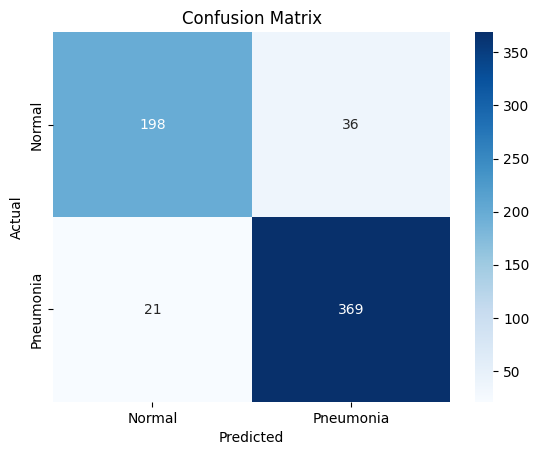


📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.85      0.87       234
   Pneumonia       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels (0 = NORMAL, 1 = PNEUMONIA)
pred_probs = model.predict(test_data)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()
true_labels = test_data.classes

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Normal", "Pneumonia"]))

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {label} ({confidence * 100:.2f}% confidence)")

In [28]:
from google.colab import files
files.upload()

Saving person100_bacteria_478.jpeg to person100_bacteria_478.jpeg


{'person100_bacteria_478.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xc0\x00\x0b\x08\x02p\x04h\x01\x01\x11\x00\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8

In [29]:
import os
os.listdir()

['.config',
 'pneumonia_detector.keras',
 'chest-xray-pneumonia.zip',
 'chest_xray',
 'pneumonia_detector.h5',
 'person100_bacteria_478.jpeg',
 'sample_data']

In [30]:
predict_image("person100_bacteria_478.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Pneumonia (99.99% confidence)
